In [162]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import font_manager as fm
from cycler import cycler
import numpy as np
from math import sqrt, pi, exp
from scipy.stats import norm
from scipy.integrate import quad
from tools import load, split, estimate_derivative, pseudoderivative, whiten
import numpy as np
from scipy.stats import pearsonr
import torch

In [163]:
def _phi(x):
    return (1.0 / sqrt(2.0 * pi)) * exp(-0.5 * x * x)


def K(r, s, atol=1e-12, rtol=1e-10):
    """
    Stable K(r, s) using Mehler's formula + numerical quadrature.
    Valid for -1 < r <= 1 (clip r just below 1 for numerical safety).
    """
    if not (0.0 < s < 1.0):
        raise ValueError("s must be in (0,1).")

    # keep r in (-1, 1); allow r=1 by integrating to 1-eps
    r = float(r)
    if r >= 1.0:
        r = np.nextafter(1.0, 0.0)
    if r <= -1.0:
        r = np.nextafter(-1.0, 0.0)

    t = float(norm.ppf(s))
    phi_t = _phi(t)
    scale = (phi_t / (1.0 - s)) ** 2

    def S(u):
        # integrand from Mehler (probabilists' Hermite)
        return (1.0 / np.sqrt(1.0 - u * u)) * np.exp((t * t) * (u / (1.0 + u)))

    I, err = quad(S, 0.0, r, epsabs=atol, epsrel=rtol, limit=200)
    return (1.0 - s) + scale * I

In [ ]:
n_hd = 10000
n_out = 3
n_train = 450
n_pairs = 10000


filename = '1_600_20'
sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(pseudoderivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))
# sensor_data = whiten(sensor_data)

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:n_train]):
    try:
        flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i + 1])
    except IndexError:
        flag = (times_sec > sequence_sec[i])
    labels[flag] = int(sequence[i][1])
idx_first_flag = np.where(labels != 0)[0][0]
# idx_last_flag = np.where(labels != 0)[0][-1]

x_dense = sensor_data[idx_first_flag:]
n_dense = x_dense.shape[1]


In [180]:
device = torch.device('mps' if torch.backends.mps.is_available() else
                       'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

d_sweep = np.logspace(-3, -1, 3)
p_sweep = [0.01, 0.03, 0.05, 0.07]

x_array = np.zeros((2, len(d_sweep), len(p_sweep), n_pairs))
y_array = np.zeros((2, len(d_sweep), len(p_sweep), n_pairs))

# Move dense data to GPU once (unnormalised — used as-is for projection)
x_dense_t = torch.tensor(x_dense, dtype=torch.float32, device=device)

# Pre-sample pairs (same pairs across all conditions = fairer comparison)
n_samples = x_dense.shape[0]
pair_indices = np.array([np.random.choice(n_samples, size=2, replace=False)
                         for _ in range(n_pairs)])
idx1 = torch.tensor(pair_indices[:, 0], device=device)
idx2 = torch.tensor(pair_indices[:, 1], device=device)

# Dense cosine similarity — normalise only here for the cos distance calculation
v1 = x_dense_t[idx1]
v2 = x_dense_t[idx2]
cos_dense = (v1 * v2).sum(dim=1) / (v1.norm(dim=1) * v2.norm(dim=1))
cos_dense_np = cos_dense.cpu().numpy().tolist()

for m, top_k in enumerate([False, True]):
    for l, p in enumerate(p_sweep):
        for j, d in enumerate(d_sweep):
            k = int(d * n_hd)

            W_hd = torch.bernoulli(torch.full((n_hd, n_dense), p, device=device))
            x_hd = x_dense_t @ W_hd.T

            # topk + scatter is faster than double argsort
            _, topk_idx = torch.topk(x_hd, k, dim=1, largest=top_k)
            z_hd = torch.zeros_like(x_hd)
            z_hd.scatter_(1, topk_idx, 1.0)

            # Vectorised pairwise similarity
            cos_hd = (z_hd[idx1] * z_hd[idx2]).sum(dim=1) / k

            x_array[m, j, l] = cos_dense_np
            y_array[m, j, l] = cos_hd.cpu().numpy().tolist()

            # print(f'Computed $d={d}$,  $p={p}$')


Using device: mps


In [ ]:
from scipy.stats import binom

rs = np.arange(0, 1.01, 0.01)
n_binom = 16
x_binom = np.arange(0, n_binom + 1)

fig, ax = plt.subplots(
    2 * len(d_sweep) + 1, len(p_sweep),
    figsize=(10, 22),
    gridspec_kw={'wspace': 0.4, 'hspace': 0.4,
                 'height_ratios': [1.2] + [1] * (2 * len(d_sweep))}
)

# ── Top row: Binomial(16, p) PMF — titles serve as column p-headers ───────
for j, p in enumerate(p_sweep):
    pmf = binom.pmf(x_binom, n_binom, p)
    ax[0, j].bar(x_binom, pmf, color='C2', width=0.8)
    ax[0, j].set_title(f'$p={p}$', fontsize=9)
    ax[0, j].set_xlabel('$x$')
    ax[0, j].set_xticks([0, 8, 16])
    if j == 0:
        ax[0, j].set_ylabel(r'$P(X{=}x)$')
    else:
        ax[0, j].set_yticklabels([])

# ── Kernel plots ──────────────────────────────────────────────────────────
for m, top_k in enumerate([True, False]):
    for i, d in enumerate(d_sweep):
        for j, p in enumerate(p_sweep):
            s = 1 - d
            vals = [K(r=ri, s=s)*(1-s) for ri in rs]

            x = np.squeeze(x_array[m, i, j])
            y = np.squeeze(y_array[m, i, j])

            row = m * len(d_sweep) + i + 1

            ax[row, j].plot(x, y, '.', alpha=1., ms=2, clip_on=False, label='Sensor data', color=f'C{m}')
            ax[row, j].plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
            ax[row, j].set_ylabel(r'$K({x}_{1}, {x}_{2})$')
            ax[row, j].set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
            ax[row, j].set_xticks([0, 0.5, 1])
            ax[row, j].set_yticks([0, 0.5, 1])

            # d label to the left of each row (leftmost column only)
            if j == 0:
                ax[row, j].text(-0.55, 0.5, f'$d={d:.3f}$',
                                transform=ax[row, j].transAxes,
                                ha='center', va='center', rotation=90, clip_on=False)

            if j != 0:
                ax[row, j].set_yticks([0, 0.5, 1], labels=[])
                ax[row, j].set_ylabel('')
            if row != 2 * len(d_sweep):
                ax[row, j].set_xticks([0, 0.5, 1], labels=[])
                ax[row, j].set_xlabel('')

# plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.show()


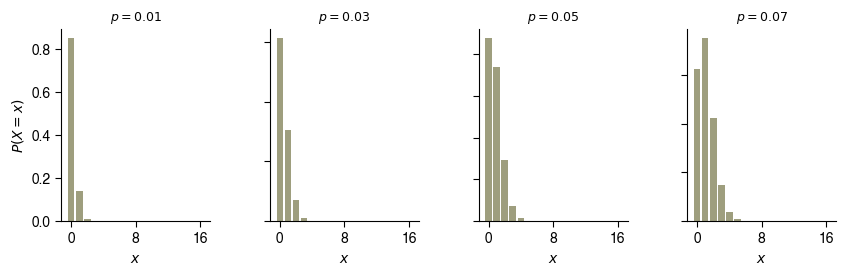

In [179]:
from scipy.stats import binom

n_binom = 16
x_binom = np.arange(0, n_binom + 1)

fig, ax = plt.subplots(1, len(p_sweep), figsize=(10, 2.5),
                       gridspec_kw={'wspace': 0.4})

for j, p in enumerate(p_sweep):
    pmf = binom.pmf(x_binom, n_binom, p)
    ax[j].bar(x_binom, pmf, color='C2', width=0.8)
    ax[j].set_title(f'$p={p}$', fontsize=9)
    ax[j].set_xlabel('$x$')
    ax[j].set_xticks([0, 8, 16])
    if j == 0:
        ax[j].set_ylabel(r'$P(X{=}x)$')
    else:
        ax[j].set_yticklabels([])

plt.show()


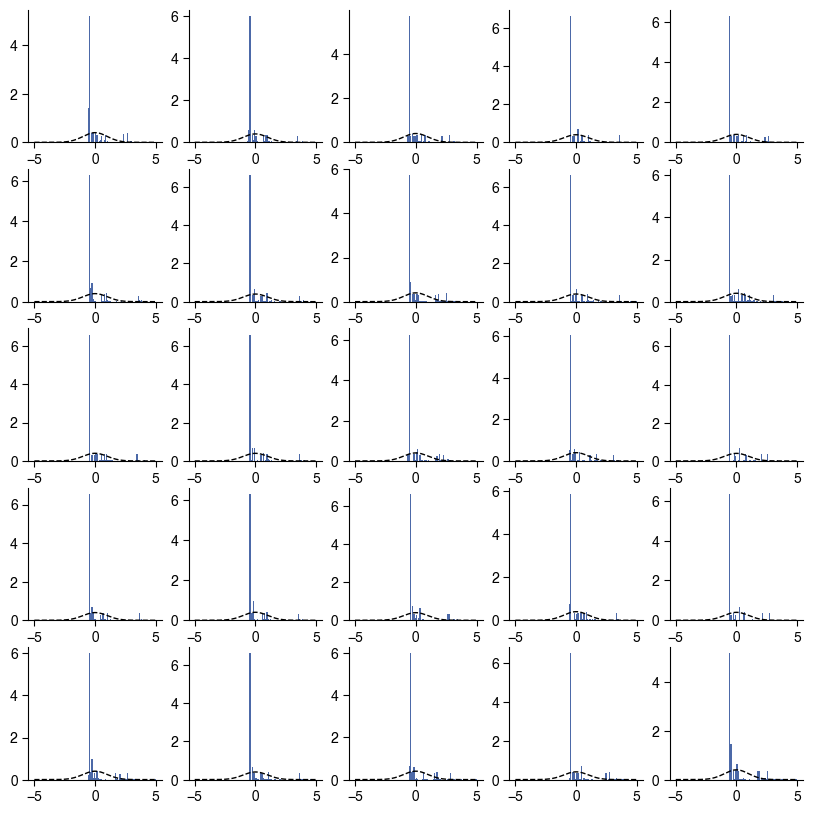

In [167]:
p = 0.05
d = 0.01
k = d*n_hd
n_idx = 25
n_init = 10

idx = np.random.randint(0, n_samples, size=(n_idx))
fig, ax = plt.subplots(5, 5, figsize=(10,10))

# N(0,1) reference curve
z_range = np.linspace(-5, 5, 200)
normal_pdf = norm.pdf(z_range)

W_hd = torch.bernoulli(torch.full((n_hd, n_dense), p, device=device))
x_hd = x_dense_t @ W_hd.T
values = x_hd[idx, :].cpu().numpy()
for l in range(n_idx):
    i = int(l/5.)
    j = int(l%5)
    mean = np.mean(values[l, :])
    std = np.std(values[l, :])
    if std == 0:
        std = 1e-6
    values_recast = (values[l, :]-mean)/std
    ax[i,j].hist(values_recast, bins=100, range=(-5, 5), density=True, color=f'C0')
    ax[i,j].plot(z_range, normal_pdf, '--', color='black', linewidth=1.)

Low input dimensionality (16) -> values of Z sample from up to 16 values, CLT approximation meh

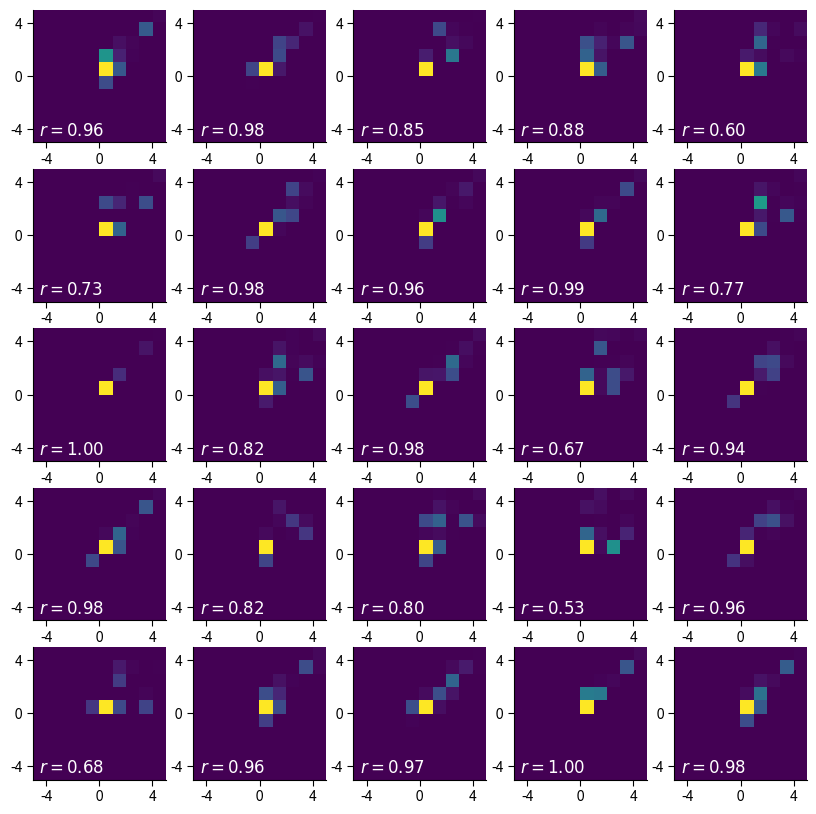

In [168]:
n_pairs = 25
res = 10
n_hmap = int(1e5)

box = np.linspace(-5, 5, res)
fig, ax = plt.subplots(5, 5, figsize=(10,10))
pair_indices = np.array([np.random.choice(n_hd, size=2, replace=False)
                         for _ in range(n_samples)])
for l in range(n_pairs):
    i = int(l/5.)
    j = int(l%5)
    idx1 = pair_indices[l][0]
    idx2 = pair_indices[l][1]
    x_hd1 = x_hd[idx1].cpu().numpy()
    x_hd2 = x_hd[idx2].cpu().numpy()
    mean1 = np.mean(x_hd1)
    mean2 = np.mean(x_hd2)
    std1 = np.std(x_hd1)
    std2 = np.std(x_hd2)
    if std1 == 0:
        std1 = 1e-6
    values_recast1 = (x_hd1-mean1)/std1
    if std2 == 0:
        std2 = 2e-6
    values_recast2 = (x_hd2-mean2)/std2
    corr = np.corrcoef(values_recast1, values_recast2)[0, 1]
    hmap = np.zeros((res,res))
    for m in range(n_hd):
        val1 = values_recast1[m]
        val2 = values_recast2[m]
        x1 = (val1 < box) & (val1 >= box - 10./res)
        x2 = (val2 < box) & (val2 >= box - 10./res)
        hmap[x1, x2] += 1

    ax[i,j].imshow(hmap,origin='lower')
    ax[i,j].set_xticks([res/10 - 0.5, res/2 - 0.5, 9*res/10 - 0.5], labels=[-4, 0, 4])
    ax[i,j].set_yticks([res/10 - 0.5, res/2 - 0.5, 9*res/10 - 0.5], labels=[-4, 0, 4])
    ax[i,j].text(0.05, 0.05,f'$r={corr:.2f}$', transform=ax[i,j].transAxes, color='white')
